## Шаг 1. Загрузка и очистка данных

### Скачиваем датасет [InstaCart Online Grocery Basket Analysis Dataset](https://www.kaggle.com/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset/data)

In [1]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install kaggle

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Настройка прав доступа 
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d "yasserh/instacart-online-grocery-basket-analysis-dataset"

Dataset URL: https://www.kaggle.com/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset
License(s): CC0-1.0
  0%|                                                | 0.00/197M [00:00<?, ?B/s]
100%|████████████████████████████████████████| 197M/197M [00:00<00:00, 2.70GB/s]


In [6]:
!unzip instacart-online-grocery-basket-analysis-dataset.zip
!rm instacart-online-grocery-basket-analysis-dataset.zip

Archive:  instacart-online-grocery-basket-analysis-dataset.zip
  inflating: aisles.csv              
  inflating: departments.csv         
  inflating: order_products__prior.csv  
  inflating: order_products__train.csv  
  inflating: orders.csv              
  inflating: products.csv            


In [1]:
import os
import pandas as pd

# Фильтруем только CSV-файлы
csv_files = [f for f in os.listdir() if f.endswith('.csv')]

for file in csv_files:
    # Формируем имя переменной
    var_name = file[:-4]  # Удаляем .csv
    # Создаем датафрейм в глобальном пространстве имен
    globals()[var_name] = pd.read_csv(file)
    print(f'Файл {file} загружен в переменную {var_name}')

Файл order_products__prior.csv загружен в переменную order_products__prior
Файл products.csv загружен в переменную products
Файл orders.csv загружен в переменную orders
Файл order_products__train.csv загружен в переменную order_products__train
Файл aisles.csv загружен в переменную aisles
Файл departments.csv загружен в переменную departments


In [3]:
import pandas as pd
import numpy as np

# 1. Объединяем информацию о товарах в заказах
combined_orders_products = pd.concat(
    [order_products__prior, order_products__train], 
    ignore_index=True
)

# Проверка полных дубликатов строк
print("Дубликаты в объединенных заказах:",
      combined_orders_products.duplicated().sum())

# Проверка логических дубликатов (один товар в одном заказе)
print("Логические дубликаты (order_id + product_id):",
      combined_orders_products.duplicated(subset=['order_id', 'product_id']).sum())

# 2. Соединяем с метаданными заказов
merged_data = orders.merge(combined_orders_products, on='order_id', how='left')

# Проверка комбинации order_id + product_id
duplicates = merged_data.duplicated(subset=['order_id', 'product_id'], keep=False)
print("Потенциальные дубликаты после объединения с orders:",
      duplicates.sum())

# 3. Добавляем информацию о продуктах
merged_data = merged_data.merge(products, on='product_id', how='inner')

# Проверка уникальности связки order + product
print("Дубликаты после добавления продуктов:",
      merged_data.duplicated(subset=['order_id', 'product_id']).sum())

# 4. Добавляем информацию об отделах (aisles)
merged_data = merged_data.merge(
    aisles,
    on='aisle_id',
    how='left'
)

# 5. Добавляем информацию о категориях (departments)
merged_data = merged_data.merge(
    departments,
    on='department_id',
    how='left'
)

final_duplicates = merged_data.duplicated(
    subset=['order_id', 'product_id', 'aisle_id', 'department_id']
).sum()

print("Итоговое количество дубликатов:", final_duplicates)

merged_data = merged_data.drop(['eval_set'], axis=1)


# Выбираем 10% случайных пользователей
unique_users = merged_data['user_id'].dropna().unique()
selected_users = np.random.choice(
    unique_users, 
    size=int(len(unique_users) * 0.1), 
    replace=False
)

# Фильтруем финальный датафрейм
merged_data_10 = merged_data[merged_data['user_id'].isin(selected_users)]

df = merged_data_10

Дубликаты в объединенных заказах: 0
Логические дубликаты (order_id + product_id): 0
Потенциальные дубликаты после объединения с orders: 0
Дубликаты после добавления продуктов: 0
Итоговое количество дубликатов: 0


In [146]:
from tabulate import tabulate
# print(tabulate(df[df['user_id']==1], headers='keys', tablefmt='pipe', showindex=False))

print('order_products__prior \n')
print(tabulate(order_products__prior.head(), headers='keys', tablefmt='pipe', showindex=False))
print('products \n')
print(tabulate(products.head(), headers='keys', tablefmt='pipe', showindex=False))
print('orders \n')
print(tabulate(orders.head(), headers='keys', tablefmt='pipe', showindex=False))
print('order_products__train \n')
print(tabulate(order_products__train.head(), headers='keys', tablefmt='pipe', showindex=False))
print('aisles \n')
print(tabulate(aisles.head(), headers='keys', tablefmt='pipe', showindex=False))
print('departments \n')
print(tabulate(departments.head(), headers='keys', tablefmt='pipe', showindex=False))

order_products__prior 

|   order_id |   product_id |   add_to_cart_order |   reordered |
|-----------:|-------------:|--------------------:|------------:|
|          2 |        33120 |                   1 |           1 |
|          2 |        28985 |                   2 |           1 |
|          2 |         9327 |                   3 |           0 |
|          2 |        45918 |                   4 |           1 |
|          2 |        30035 |                   5 |           0 |
products 

|   product_id | product_name                                                      |   aisle_id |   department_id |
|-------------:|:------------------------------------------------------------------|-----------:|----------------:|
|            1 | Chocolate Sandwich Cookies                                        |         61 |              19 |
|            2 | All-Seasons Salt                                                  |        104 |              13 |
|            3 | Robust Golden Unsweete

## EDA

In [4]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Настройка визуализаций
plt.style.use('seaborn-v0_8')  # Новое название стиля для современных версий


sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

In [5]:
# 1. Первичный осмотр данных
print("Первые 5 строк:")
df.head()

Первые 5 строк:


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
744,280530,9,1,1,17,NaN,27973.0,1.0,0.0,Almond Non-Dairy Yogurt Made From Real Almonds...,120,16,yogurt,dairy eggs
745,280530,9,1,1,17,NaN,481.0,2.0,0.0,Black Peppercorns,104,13,spices seasonings,pantry
746,280530,9,1,1,17,NaN,27966.0,3.0,0.0,Organic Raspberries,123,4,packaged vegetables fruits,produce
747,280530,9,1,1,17,NaN,33754.0,4.0,0.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs
748,280530,9,1,1,17,NaN,4957.0,5.0,0.0,Total 2% Lowfat Greek Strained Yogurt With Blu...,120,16,yogurt,dairy eggs


In [6]:
print("\nИнформация о данных:")
df.info()


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
Index: 3410234 entries, 744 to 33817348
Data columns (total 14 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              float64
 7   add_to_cart_order       float64
 8   reordered               float64
 9   product_name            object 
 10  aisle_id                int64  
 11  department_id           int64  
 12  aisle                   object 
 13  department              object 
dtypes: float64(4), int64(7), object(3)
memory usage: 390.3+ MB


In [7]:
print("\nОписательная статистика:")
df.describe()


Описательная статистика:


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
count,3.410234e+06,3.410234e+06,3.410234e+06,3.410234e+06,3.410234e+06,3.201708e+06,3.410234e+06,3.410234e+06,3.410234e+06,3.410234e+06,3.410234e+06
mean,1.708652e+06,1.034334e+05,1.727546e+01,2.724252e+00,1.343530e+01,1.130036e+01,2.559044e+04,8.439883e+00,5.916521e-01,7.123094e+01,9.922038e+00
std,9.873248e+05,5.931408e+04,1.758719e+01,2.088842e+00,4.264927e+00,8.921667e+00,1.409154e+04,7.214127e+00,4.915282e-01,3.822505e+01,6.282033e+00
min,3.000000e+00,9.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,8.533510e+05,5.198300e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00,1.353500e+04,3.000000e+00,0.000000e+00,3.100000e+01,4.000000e+00
50%,1.709157e+06,1.036450e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00,2.525600e+04,6.000000e+00,1.000000e+00,8.300000e+01,9.000000e+00
75%,2.560580e+06,1.545360e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01,3.800300e+04,1.200000e+01,1.000000e+00,1.070000e+02,1.600000e+01
max,3.421053e+06,2.062010e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,4.968800e+04,1.020000e+02,1.000000e+00,1.340000e+02,2.100000e+01


In [8]:
# Проверка уникальных значений
print("\nУникальные значения order_dow:", df['order_dow'].unique())
print("Уникальных пользователей:", df['user_id'].nunique())
print("Уникальных заказов:", df['order_id'].nunique())


Уникальные значения order_dow: [1 0 5 6 2 4 3]
Уникальных пользователей: 20620
Уникальных заказов: 335948


In [9]:
# 3. Анализ пропущенных значений
df.isnull().sum()

order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    208526
product_id                     0
add_to_cart_order              0
reordered                      0
product_name                   0
aisle_id                       0
department_id                  0
aisle                          0
department                     0
dtype: int64

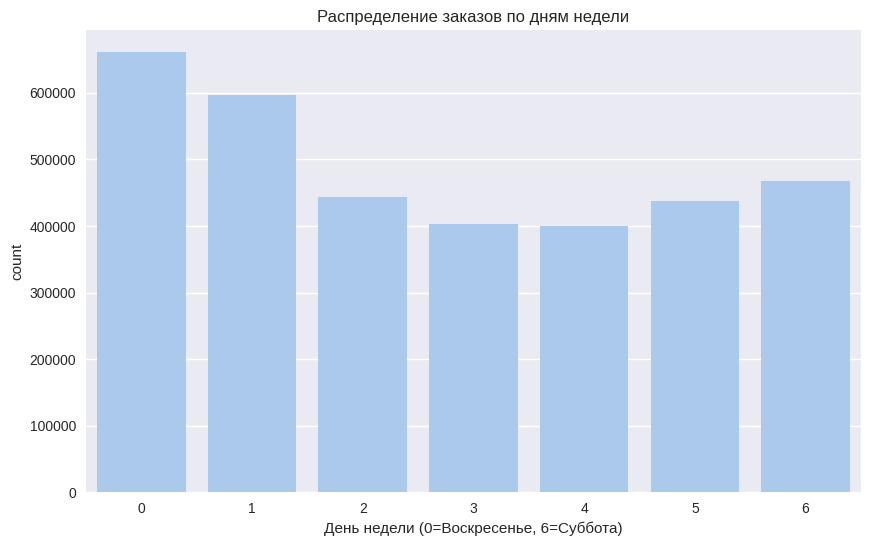

In [10]:
# 4. Анализ временных параметров заказов
# Распределение дней недели
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='order_dow', data=df)
ax.set_title('Распределение заказов по дням недели')
ax.set_xlabel('День недели (0=Воскресенье, 6=Суббота)')
plt.show()

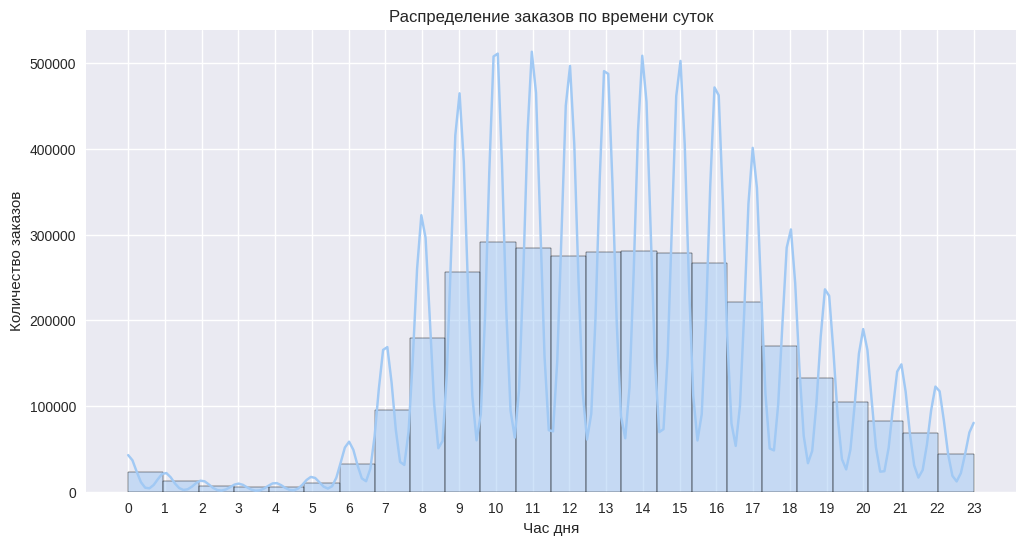

In [11]:
# Распределение времени заказов
plt.figure(figsize=(12, 6))
sns.histplot(df['order_hour_of_day'], bins=24, kde=True)
plt.title('Распределение заказов по времени суток')
plt.xlabel('Час дня')
plt.ylabel('Количество заказов')
plt.xticks(range(0, 24))
plt.show()

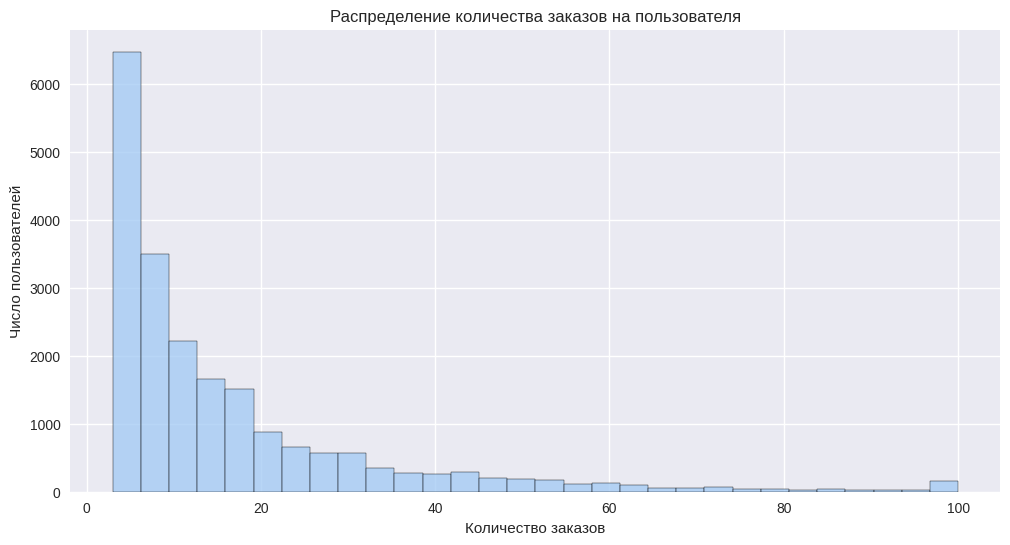

In [12]:
# 5. Анализ поведения пользователей
# Распределение количества заказов на пользователя
user_orders = df.groupby('user_id')['order_number'].max()
plt.figure(figsize=(12, 6))
sns.histplot(user_orders, bins=30, kde=False)
plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Количество заказов')
plt.ylabel('Число пользователей')
plt.show()

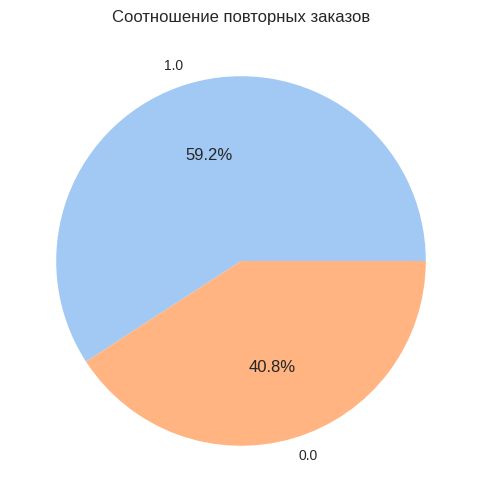

In [13]:
# Анализ повторных заказов
plt.figure(figsize=(8, 6))
df['reordered'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Соотношение повторных заказов')
plt.ylabel('')
plt.show()

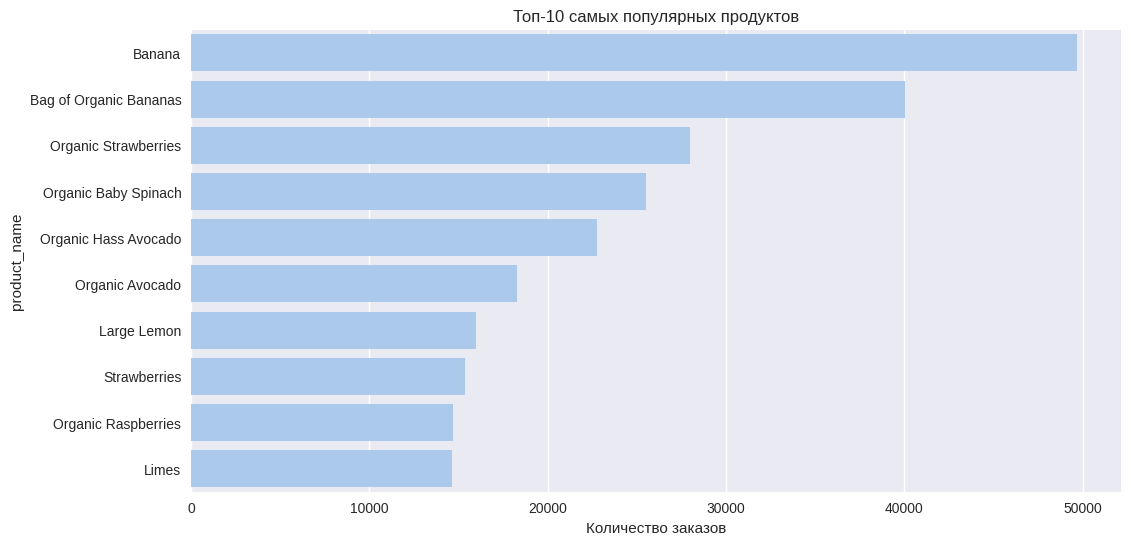

In [14]:
# 6. Анализ продуктов и категорий
# Топ-10 популярных продуктов
top_products = df['product_name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Количество заказов')
plt.show()

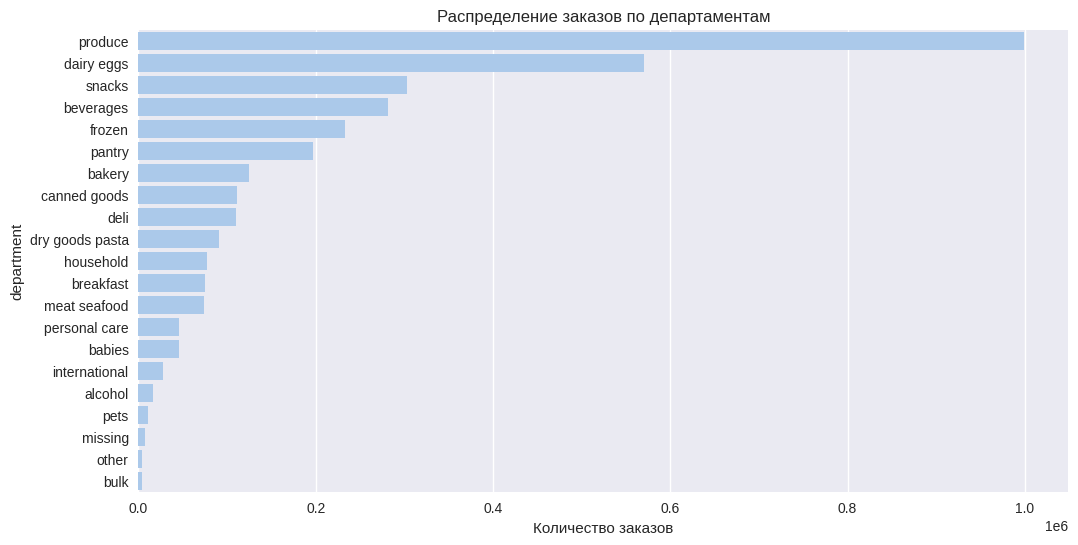

In [15]:
# Распределение по департаментам
plt.figure(figsize=(12, 6))
department_dist = df['department'].value_counts()
sns.barplot(x=department_dist.values, y=department_dist.index)
plt.title('Распределение заказов по департаментам')
plt.xlabel('Количество заказов')
plt.show()

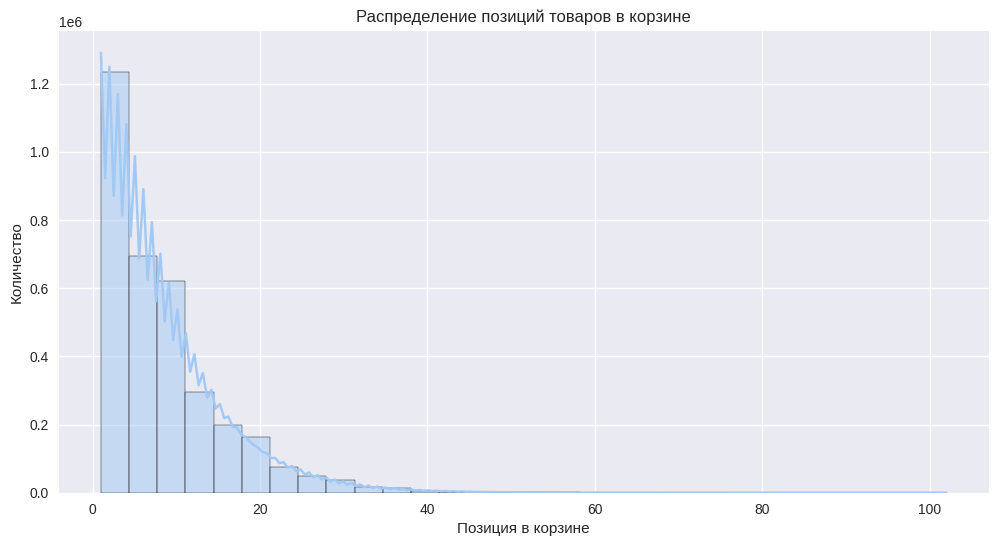

In [16]:
# 7. Анализ корзины покупок
# Распределение позиций товаров в корзине
plt.figure(figsize=(12, 6))
sns.histplot(df['add_to_cart_order'], bins=30, kde=True)
plt.title('Распределение позиций товаров в корзине')
plt.xlabel('Позиция в корзине')
plt.ylabel('Количество')
plt.show()

In [17]:
# Средний размер корзины
avg_basket_size = df.groupby('order_id')['add_to_cart_order'].max().mean()
print(f"\nСредний размер корзины: {avg_basket_size:.1f} товаров")


Средний размер корзины: 10.2 товаров


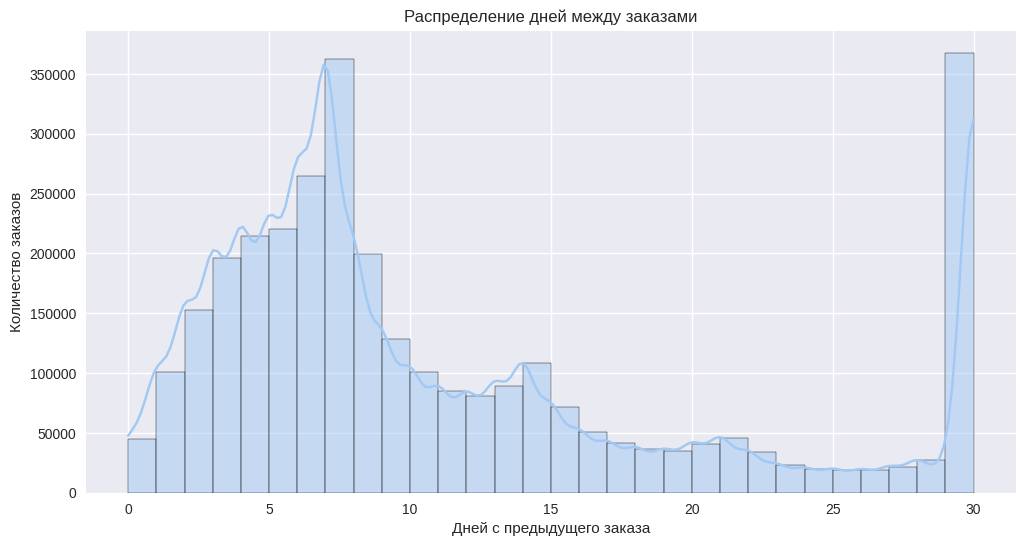

In [18]:
# ==============================================
# 8. Анализ временных интервалов между заказами
# ==============================================
plt.figure(figsize=(12, 6))
sns.histplot(df['days_since_prior_order'].dropna(), bins=30, kde=True)
plt.title('Распределение дней между заказами')
plt.xlabel('Дней с предыдущего заказа')
plt.ylabel('Количество заказов')
plt.show()

## BaseLine

### Popularity-Based Recommendations

Metrics:
- precision@10: 0.0724
- recall@10: 0.07
- hit_rate@10: 0.4567
- coverage: 0.0004

In [19]:
import pandas as pd
import numpy as np
from collections import defaultdict

# 1. Подготовка данных
def prepare_data(data):
    # Сортировка по пользователям и номерам заказов
    data = data.sort_values(['user_id', 'order_number'])
    
    # Создание словаря для разделения на train/test
    user_last_order = data.groupby('user_id')['order_number'].max().reset_index()
    user_last_order.columns = ['user_id', 'last_order']
    
    # Объединение с исходными данными
    merged = data.merge(user_last_order, on='user_id')
    
    # Разделение на train и test
    train = merged[merged['order_number'] < merged['last_order']]
    test = merged[merged['order_number'] == merged['last_order']]
    
    return train, test

In [20]:
# 2. Построение рекомендательной модели
class PopularityRecommender:
    def __init__(self, n_recommendations=10):
        self.n = n_recommendations
        self.popular_items = None
    
    def fit(self, train_data):
        # Подсчет популярности товаров
        item_popularity = train_data.groupby('product_id')['user_id'].nunique().reset_index()
        item_popularity.columns = ['product_id', 'popularity_score']
        
        # Сортировка по популярности
        self.popular_items = item_popularity.sort_values('popularity_score', ascending=False)['product_id'].values
    
    def recommend(self, user_id=None):
        # Для всех пользователей рекомендуем топ-N
        return self.popular_items[:self.n]

In [21]:
# 3. Расчет метрик
def calculate_metrics(test_data, recommendations, all_items):
    # Сбор данных для расчетов
    user_hits = defaultdict(list)
    all_test_items = set()
    recommended_items = set(recommendations)
    
    # Перебор всех пользователей в тестовой выборке
    for user_id in test_data['user_id'].unique():
        user_products = test_data[test_data['user_id'] == user_id]['product_id'].unique()
        all_test_items.update(user_products)
        
        # Расчет попаданий
        hits = np.isin(recommendations, user_products)
        user_hits[user_id] = {
            'hits': hits.sum(),
            'total_relevant': len(user_products)
        }
    
    # Расчет Precision@10
    precision = np.mean([v['hits']/len(recommendations) for v in user_hits.values()])
    
    # Расчет Recall@10
    recall = np.mean([
        v['hits']/v['total_relevant'] if v['total_relevant'] > 0 else 0 
        for v in user_hits.values()
    ])
    
    # Расчет Hit Rate@10
    hit_rate = np.mean([v['hits'] > 0 for v in user_hits.values()])
    
    # Расчет Coverage
    coverage = len(recommended_items & all_test_items)/len(all_test_items) if len(all_test_items) > 0 else 0
    
    return {
        'precision@10': round(precision, 4),
        'recall@10': round(recall, 4),
        'hit_rate@10': round(hit_rate, 4),
        'coverage': round(coverage, 4)
    }

In [22]:
# Основной пайплайн
def main_pipeline(data):
    # 1. Подготовка данных
    train, test = prepare_data(data)
    
    # 2. Обучение модели
    model = PopularityRecommender(n_recommendations=10)
    model.fit(train)
    
    # 3. Формирование рекомендаций
    recommendations = model.recommend()
    
    # 4. Расчет метрик
    all_items = data['product_id'].unique()
    metrics = calculate_metrics(test, recommendations, all_items)
    
    return metrics

# Запуск пайплайна
result_metrics = main_pipeline(df)
print("\nОценка рекомендательной системы:")
for metric, value in result_metrics.items():
    print(f"{metric}: {value}")


Оценка рекомендательной системы:
precision@10: 0.0724
recall@10: 0.07
hit_rate@10: 0.4567
coverage: 0.0004


### Косинусное Сходство
Metrics:
- precision@10: 0.0226
- recall@10: 0.0231
- hit_rate@10: 0.1777
- coverage: 0.0697

In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from collections import defaultdict

In [24]:
class CosineSimilarityRecommender:
    def __init__(self, n_recommendations=10, n_neighbors=50):
        self.n_recommendations = n_recommendations
        self.n_neighbors = n_neighbors
        self.user_item_matrix = None
        self.user_similarities = None
        self.item_ids = None
        self.user_id_map = None
        
    def prepare_data(self, data):
        # Создание user-item матрицы
        user_item = data.groupby(['user_id', 'product_id']).size().unstack(fill_value=0)
        self.item_ids = user_item.columns
        self.user_id_map = {uid: idx for idx, uid in enumerate(user_item.index)}
        
        # Преобразование в бинарные значения (1 - покупка, 0 - нет)
        self.user_item_matrix = csr_matrix((user_item.values > 0).astype(int))
        
    def fit(self):
        # Вычисление косинусного сходства
        self.user_similarities = cosine_similarity(self.user_item_matrix)
        
    def recommend(self, user_id):
        user_idx = self.user_id_map.get(user_id, -1)
        if user_idx == -1:
            return []
            
        # Получение индексов похожих пользователей
        sim_scores = list(enumerate(self.user_similarities[user_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:self.n_neighbors+1]
        
        # Сбор рекомендаций
        item_scores = defaultdict(float)
        purchased = set(self.user_item_matrix[user_idx].indices)
        
        for neighbor_idx, score in sim_scores:
            items = self.user_item_matrix[neighbor_idx].indices
            for item in items:
                if item not in purchased:
                    item_scores[item] += score
        
        # Сортировка и выбор топ-N
        recommendations = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)[:self.n_recommendations]
        return [self.item_ids[idx] for idx, _ in recommendations]

In [25]:
# Расчет метрик (адаптированная версия из предыдущего решения)
def calculate_metrics(test_data, recommender, all_items):
    user_hits = defaultdict(list)
    all_test_items = set(test_data['product_id'].unique())
    recommended_items = set()
    
    for user_id in test_data['user_id'].unique():
        user_products = test_data[test_data['user_id'] == user_id]['product_id'].unique()
        recs = recommender.recommend(user_id)
        recommended_items.update(recs)
        
        hits = len(set(recs) & set(user_products))
        user_hits[user_id] = {
            'hits': hits,
            'total_relevant': len(user_products)
        }
    
    precision = np.mean([v['hits']/len(recs) for v in user_hits.values() if len(recs) > 0])
    recall = np.mean([v['hits']/v['total_relevant'] if v['total_relevant'] > 0 else 0 for v in user_hits.values()])
    hit_rate = np.mean([v['hits'] > 0 for v in user_hits.values()])
    coverage = len(recommended_items & all_test_items)/len(all_test_items) if len(all_test_items) > 0 else 0
    
    return {
        'precision@10': round(precision, 4),
        'recall@10': round(recall, 4),
        'hit_rate@10': round(hit_rate, 4),
        'coverage': round(coverage, 4)
    }

In [26]:
# Основной пайплайн
def main_pipeline(data):
    # Подготовка train/test
    data = data.sort_values(['user_id', 'order_number'])
    
    # Создаем метку последнего заказа для каждого пользователя
    user_last_order = data.groupby('user_id')['order_number'].max().reset_index()
    user_last_order.columns = ['user_id', 'last_order']  # Важное исправление!
    
    merged = data.merge(user_last_order, on='user_id')
    
    # Разделение данных
    train = merged[merged['order_number'] < merged['last_order']]
    test = merged[merged['order_number'] == merged['last_order']]
    
    # Инициализация и обучение модели
    recommender = CosineSimilarityRecommender(n_recommendations=10)
    recommender.prepare_data(train)
    recommender.fit()
    
    # Расчет метрик
    all_items = data['product_id'].unique()
    metrics = calculate_metrics(test, recommender, all_items)
    
    return metrics

In [27]:
# Запуск системы
result_metrics = main_pipeline(df)
print("\nОценка рекомендательной системы (Cosine Similarity):")
for metric, value in result_metrics.items():
    print(f"{metric}: {value}")


Оценка рекомендательной системы (Cosine Similarity):
precision@10: 0.0226
recall@10: 0.0231
hit_rate@10: 0.1777
coverage: 0.0697


In [64]:
# После загрузки product_ids
print("Пример соответствия ID и кодов:")
print(pd.DataFrame({'product_id': product_ids[:10], 'code': range(10)}))

Пример соответствия ID и кодов:
   product_id  code
0           1     0
1           2     1
2           3     2
3           4     3
4           5     4
5           8     5
6           9     6
7          10     7
8          11     8
9          12     9


In [65]:
# Для случайного товара
sample_product = product_ids[100]
print(f"Сходство для {sample_product}:")
print(cosine_sim[100].toarray())

Сходство для 123:
[[0. 0. 0. ... 0. 0. 0.]]


In [66]:
test_user = test['user_id'].iloc[0]
print(f"\nТест для пользователя {test_user}:")
recs = recommend_item_item(test_user)
print("Рекомендации:", recs)
print("Реальные покупки:", test[test['user_id'] == test_user]['product_id'].values)


Тест для пользователя 1:
Рекомендации: [24852, 20940, 38689, 39180, 12384, 24024, 29447, 13176, 1729, 44799]
Реальные покупки: [  196 25133 38928 26405 39657 10258 13032 26088 27845 49235 46149]


### Матричная факторизация с использованием Alternating Least Squares (ALS)
Metrics:
- precision@10: 0.0008
- recall@10: 0.0002
- hit_rate@10: 0.0030
- coverage: 0.0219

precision@10: 0.0008
recall@10: 0.0009
hit_rate@10: 0.0084
coverage: 0.055

In [41]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from collections import defaultdict

In [42]:
class MatrixFactorizationRecommender:
    def __init__(self, n_factors=50, n_iter=15, alpha=0.01, reg=0.1, n_recommendations=10):
        self.n_factors = n_factors
        self.n_iter = n_iter
        self.alpha = alpha
        self.reg = reg
        self.n_rec = n_recommendations
        self.user_factors = None
        self.item_factors = None
        self.user_id_map = None
        self.item_id_map = None
    
    def prepare_data(self, data):
        # Создание маппингов для пользователей и товаров
        unique_users = data['user_id'].unique()
        unique_items = data['product_id'].unique()
        
        self.user_id_map = {uid: idx for idx, uid in enumerate(unique_users)}
        self.item_id_map = {iid: idx for idx, iid in enumerate(unique_items)}
        
        # Создание разреженной матрицы взаимодействий
        rows = data['user_id'].map(self.user_id_map)
        cols = data['product_id'].map(self.item_id_map)
        values = np.ones(len(data))  # Бинарные взаимодействия
        
        self.interactions = csr_matrix((values, (rows, cols)), 
                                      shape=(len(unique_users), len(unique_items)))
    
    def fit(self):
        # Инициализация матриц факторов
        n_users, n_items = self.interactions.shape
        self.user_factors = np.random.normal(scale=0.1, size=(n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=0.1, size=(n_items, self.n_factors))
        
        # ALS оптимизация
        for _ in range(self.n_iter):
            # Оптимизация пользовательских факторов
            self.user_factors = self._als_step(self.interactions, self.item_factors, self.user_factors)
            
            # Оптимизация товарных факторов
            self.item_factors = self._als_step(self.interactions.T, self.user_factors, self.item_factors)
    
    def _als_step(self, interactions, fixed_factors, factors_to_update):
        # Решение задачи оптимизации с регуляризацией
        lambda_eye = self.reg * np.eye(self.n_factors)
        for i in range(factors_to_update.shape[0]):
            # Вычисление для каждого пользователя/товара
            interactions_i = interactions[i].toarray().ravel()
            mask = interactions_i > 0
            if np.sum(mask) == 0:
                continue
            
            X = fixed_factors[mask]
            y = interactions_i[mask]
            
            A = X.T.dot(X) + lambda_eye * X.shape[0]
            b = X.T.dot(y)
            
            factors_to_update[i] = np.linalg.solve(A, b)
        return factors_to_update
    
    def recommend(self, user_id):
        if user_id not in self.user_id_map:
            return []
            
        user_idx = self.user_id_map[user_id]
        purchased = self.interactions[user_idx].indices
        
        # Предсказание рейтингов
        scores = self.user_factors[user_idx].dot(self.item_factors.T)
        
        # Исключение уже купленных товаров
        scores[purchased] = -np.inf
        
        # Выбор топ-N рекомендаций
        top_items = np.argsort(scores)[::-1][:self.n_rec]
        return [list(self.item_id_map.keys())[list(self.item_id_map.values()).index(i)] for i in top_items]

In [43]:
# Модифицированный пайплайн с проверкой данных
def main_pipeline(data):
    # Проверка обязательных колонок
    required_columns = ['user_id', 'product_id', 'order_number']
    assert all(col in data.columns for col in required_columns), "Отсутствуют необходимые колонки"
    
    # Подготовка train/test
    data = data.sort_values(['user_id', 'order_number'])
    user_last_order = data.groupby('user_id')['order_number'].max().reset_index()
    user_last_order.columns = ['user_id', 'last_order']
    
    merged = data.merge(user_last_order, on='user_id')
    train = merged[merged['order_number'] < merged['last_order']]
    test = merged[merged['order_number'] == merged['last_order']]
    
    # Инициализация и обучение модели
    model = MatrixFactorizationRecommender(n_factors=32, n_iter=20)
    model.prepare_data(train)
    model.fit()
    
    # Расчет метрик (используем предыдущую функцию calculate_metrics)
    all_items = data['product_id'].unique()
    metrics = calculate_metrics(test, model, all_items)
    
    return metrics

In [44]:
# Запуск системы
result_metrics = main_pipeline(df)
print("\nОценка рекомендательной системы (Matrix Factorization):")
for metric, value in result_metrics.items():
    print(f"{metric}: {value}")


Оценка рекомендательной системы (Matrix Factorization):
precision@10: 0.0008
recall@10: 0.0009
hit_rate@10: 0.0084
coverage: 0.055


### Two Tower

In [133]:
pip install faiss-gpu

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.9 MB/s eta 0:00:000m eta 0:00:010:01:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [137]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [138]:
# 1. Подготовка данных --------------------------------------------------------
# Проверка и очистка данных
print("Проверка данных перед обработкой:")
print(f"Количество строк: {len(df)}, NaN в данных: {df.isnull().sum().sum()}")

# Заполнение пропусков в days_since_prior_order
df['days_since_prior_order'].fillna(0, inplace=True)

Проверка данных перед обработкой:
Количество строк: 1384617, NaN в данных: 0


In [139]:
# Кодирование категориальных признаков
user_features = df.groupby('user_id').agg({
    'order_dow': ['mean', 'std'],
    'order_hour_of_day': ['mean', 'std'],
    'days_since_prior_order': ['mean', 'std'],
    'department': lambda x: x.mode()[0]
}).reset_index()
user_features.columns = ['user_id', 'dow_mean', 'dow_std', 
                        'hour_mean', 'hour_std', 
                        'days_mean', 'days_std', 'fav_dept']

item_features = df.groupby('product_id').agg({
    'aisle': 'first',
    'department': 'first',
    'reordered': 'mean'
}).reset_index()

# Кодируем категории
dept_encoder = LabelEncoder()
aisle_encoder = LabelEncoder()

user_features['fav_dept'] = dept_encoder.fit_transform(user_features['fav_dept'])
item_features['aisle'] = aisle_encoder.fit_transform(item_features['aisle'])
item_features['department'] = dept_encoder.transform(item_features['department'])

# Нормализация числовых признаков
scaler = StandardScaler()
user_features[['dow_mean', 'dow_std', 'hour_mean', 'hour_std', 
              'days_mean', 'days_std']] = scaler.fit_transform(
                  user_features[['dow_mean', 'dow_std', 'hour_mean', 'hour_std',
                               'days_mean', 'days_std']]
              )

In [124]:
# 2. Создание датасета --------------------------------------------------------
class SafeRecommendationDataset(Dataset):
    def __init__(self, interactions, user_features, item_features):
        self.interactions = interactions
        self.user_features = user_features.set_index('user_id')
        self.item_features = item_features.set_index('product_id')
        self.valid_pairs = self._filter_valid_pairs()

    def _filter_valid_pairs(self):
        valid = []
        for user_id, item_id, label in self.interactions:
            if user_id in self.user_features.index and item_id in self.item_features.index:
                valid.append((user_id, item_id, label))
        return valid

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, idx):
        user_id, item_id, label = self.valid_pairs[idx]
        user_feat = self.user_features.loc[user_id].values
        item_feat = self.item_features.loc[item_id].values
        return {
            'user': torch.tensor(user_feat, dtype=torch.float),
            'item': torch.tensor(item_feat, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.float)
        }

In [134]:
# 3. Архитектура модели -------------------------------------------------------
class TwoTower(nn.Module):
    def __init__(self, user_dim, item_dim, embedding_dim=64):
        super().__init__()
        
        # User Tower
        self.user_net = nn.Sequential(
            nn.Linear(user_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )
        
        # Item Tower
        self.item_net = nn.Sequential(
            nn.Linear(item_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )
        
        # Инициализация весов
        for layer in [self.user_net, self.item_net]:
            for module in layer:
                if isinstance(module, nn.Linear):
                    nn.init.xavier_normal_(module.weight)
                    nn.init.constant_(module.bias, 0.01)

    def forward(self, user, item):
        user_embed = F.normalize(self.user_net(user), p=2, dim=1)
        item_embed = F.normalize(self.item_net(item), p=2, dim=1)
        return torch.sum(user_embed * item_embed, dim=1)

In [135]:
# 4. Обучение модели ----------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoTower(user_dim, item_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Функция для проверки NaN
def check_nan(tensor, name):
    if torch.isnan(tensor).any():
        raise ValueError(f"NaN detected in {name}")

# Цикл обучения
for epoch in range(10):
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        user = batch['user'].to(device)
        item = batch['item'].to(device)
        label = batch['label'].to(device)
        
        # Проверка входных данных
        check_nan(user, "User features")
        check_nan(item, "Item features")
        check_nan(label, "Labels")
        
        optimizer.zero_grad()
        outputs = model(user, item)
        
        # Проверка выходов модели
        check_nan(outputs, "Model outputs")
        
        loss = criterion(outputs, label)
        check_nan(loss, "Loss")
        
        loss.backward()
        # Клиппинг градиентов
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

Epoch 1:   0%|                                         | 0/1082 [00:00<?, ?it/s]


ValueError: NaN detected in User features

In [128]:
# 5. Генерация рекомендаций ---------------------------------------------------
def recommend_two_tower(user_id, k=10):
    model.eval()
    
    # Кэшируем все item эмбеддинги
    item_tensors = torch.tensor(item_features.iloc[:, 1:].values, dtype=torch.float).to(device)
    with torch.no_grad():
        item_embeds = model.item_net(item_tensors)
    
    # Эмбеддинг пользователя
    try:
        user_feat = user_features.loc[user_id].values[1:]
    except KeyError:
        return popularity_df.head(k).index.tolist()
    
    user_tensor = torch.tensor(user_feat, dtype=torch.float).to(device).unsqueeze(0)
    with torch.no_grad():
        user_embed = model.user_net(user_tensor)
    
    # Быстрый поиск через FAISS
    import faiss
    index = faiss.IndexFlatIP(64)
    index.add(item_embeds.cpu().numpy())
    distances, indices = index.search(user_embed.cpu().numpy(), k)
    
    return item_features.iloc[indices[0]]['product_id'].tolist()

In [132]:
# 6. Оценка качества ----------------------------------------------------------
# Используем функцию evaluate_item_item из предыдущего кода
print("\nTwo Tower Metrics:")
two_tower_metrics = evaluate_item_item(test, recommend_two_tower)
for metric, value in two_tower_metrics.items():
    print(f"{metric}: {value:.4f}")


Two Tower Metrics:


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.20it/s]

precision@10: 0.0000
recall@10: 0.0000
hit_rate@10: 0.0000
coverage: 0.0000
